In [ ]:
pip install torch torchvision matplotlib seaborn opencv-python scikit-learn


100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


Epoch [1/15], Loss: 2.0271
Epoch [2/15], Loss: 1.9474
Epoch [3/15], Loss: 1.9324
Epoch [4/15], Loss: 1.9181
Epoch [5/15], Loss: 1.9065
Epoch [6/15], Loss: 1.8975
Epoch [7/15], Loss: 1.8972
Epoch [8/15], Loss: 1.8954
Epoch [9/15], Loss: 1.8898
Epoch [10/15], Loss: 1.8824
Epoch [11/15], Loss: 1.8831
Epoch [12/15], Loss: 1.8790
Epoch [13/15], Loss: 1.8710
Epoch [14/15], Loss: 1.8737
Epoch [15/15], Loss: 1.8684
Test Accuracy: 36.59%


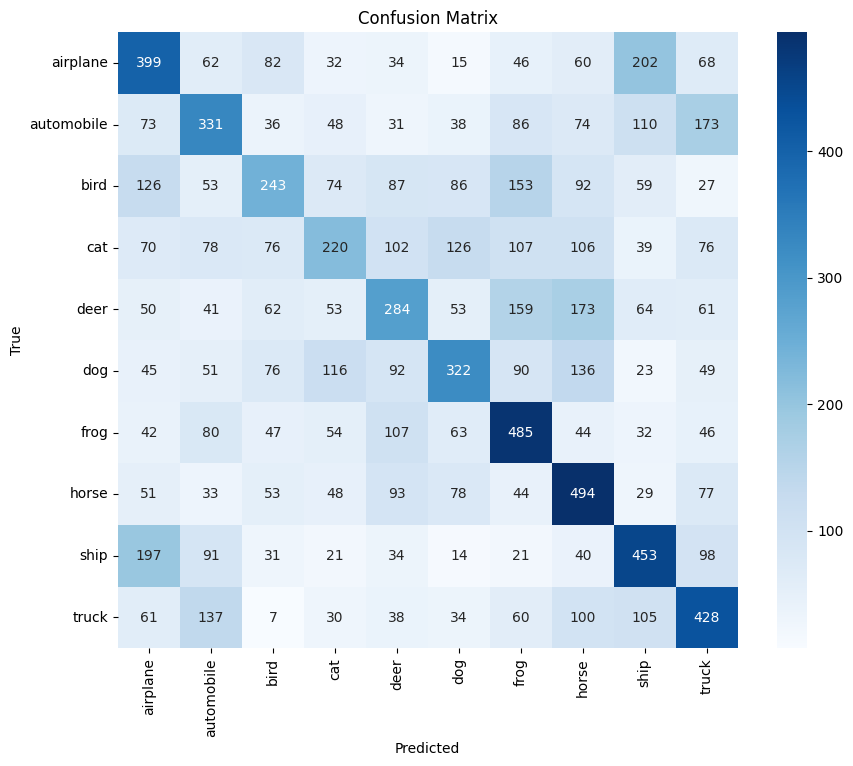

              precision    recall  f1-score   support

    airplane       0.36      0.40      0.38      1000
  automobile       0.35      0.33      0.34      1000
        bird       0.34      0.24      0.28      1000
         cat       0.32      0.22      0.26      1000
        deer       0.31      0.28      0.30      1000
         dog       0.39      0.32      0.35      1000
        frog       0.39      0.48      0.43      1000
       horse       0.37      0.49      0.43      1000
        ship       0.41      0.45      0.43      1000
       truck       0.39      0.43      0.41      1000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.36     10000
weighted avg       0.36      0.37      0.36     10000



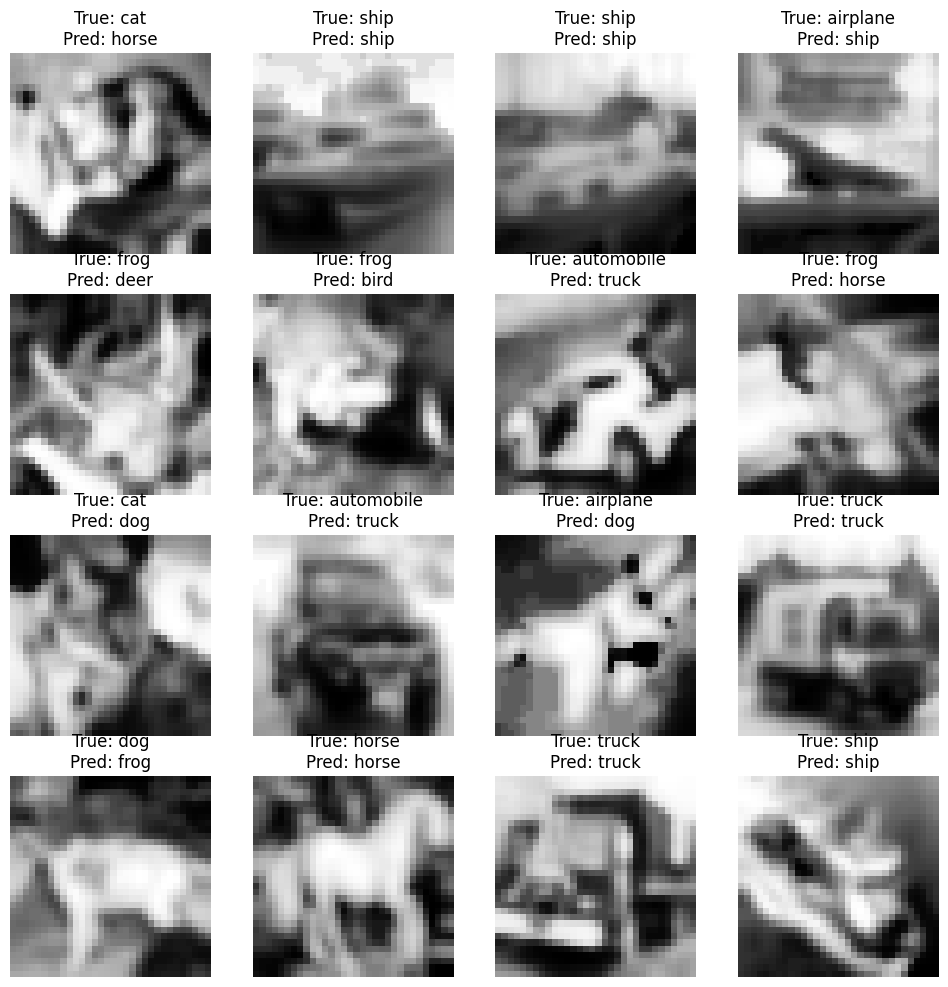

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. OpenCV preprocessing for CIFAR-10
class OpenCVTransform:
    def __init__(self):
        # CIFAR-10 images are 32x32, so no resizing is required
        pass

    def __call__(self, image):
        # Convert PIL image to numpy array
        image = np.array(image)

        # Apply Gaussian blur
        image = cv2.GaussianBlur(image, (3, 3), 0)

        # Apply histogram equalization for better contrast
        image = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

        # Normalize to 0-1
        image = image / 255.0

        # Stack into 3 channels (since models like ResNet expect RGB input)
        image = np.stack([image, image, image], axis=-1)

        # Transpose to (C, H, W)
        image = np.transpose(image, (2, 0, 1))

        return torch.tensor(image, dtype=torch.float32)

# Define data transformations
transform_train = transforms.Compose([
    OpenCVTransform(),
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    OpenCVTransform(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2. Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 3. Fine-tuning with ResNet18
class ResNetTransferLearning(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetTransferLearning, self).__init__()
        # Load the pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)

        # Freeze the convolutional base
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the fully connected layer for CIFAR-10 classification
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

model = ResNetTransferLearning(num_classes=10).to(device)

# 4. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)

# 5. Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=15):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

# 6. Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return all_labels, all_preds

# 7. Confusion Matrix and Classification Report
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 8. Visualize predictions
def visualize_predictions(model, test_loader, class_names):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    # Plot the first 16 images
    plt.figure(figsize=(12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        image = images[i].cpu().permute(1, 2, 0)  # Convert to (H, W, C)
        image = (image * 0.5 + 0.5).numpy()  # De-normalize
        plt.imshow(image)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.show()

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, epochs=15)
true_labels, pred_labels = evaluate_model(model, test_loader)

# Plot confusion matrix and classification report
class_names = train_dataset.classes
plot_confusion_matrix(true_labels, pred_labels, class_names)
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Visualize predictions
visualize_predictions(model, test_loader, class_names)
